In [4]:
from google.colab import drive
import pandas as pd

# This will prompt for authorization to access your Google Drive
drive.mount('/content/drive')

# Update the file path to the location where you uploaded your CSV in Google Drive
file_path = '/content/drive/My Drive/Thesis/df-englisch_cat.csv'

# Read the CSV file
df = pd.read_csv(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from ast import literal_eval

df = df.drop(df.columns[0], axis=1)


df["ada_embedding_eng"] = df["ada_embedding_eng"].apply(literal_eval).apply(np.array)

# Separating the target variable and embeddings
x = df["ada_embedding_eng"]
y = df['numerical_price']

# Dropping the 'ada_embedding_eng' column from df
z = df.drop(["ada_embedding_eng", "numerical_price"], axis=1)

# Deleting original dataframe for memory purpose
del df

# Explode the embedding arrays into separate columns
x = x.apply(pd.Series)

# Concatenating the exploded embeddings with the rest of the data
concatenated_df = pd.concat([x, z], axis=1).reset_index(drop=True)
concatenated_df.columns = concatenated_df.columns.astype(str)


x_train, x_test, y_train, y_test = train_test_split(concatenated_df, y, test_size=0.2, random_state=42)
# Now, sample 10000 instances from the remaining training set for hyperparameter tuning
x_train = x_train.sample(10000, random_state=42)
y_train = y_train.loc[x_train.index]


In [6]:
!pip install optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import optuna

def Objective_nn_mixed(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.01, log=False)
    neurons_layer_1 = trial.suggest_int("neurons_layer_1", 16, 1024, step=16)
    neurons_layer_2 = trial.suggest_int("neurons_layer_2", 16, 512, step=16)
    neurons_layer_3 = trial.suggest_int("neurons_layer_3", 16, 256, step=16)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    epochs = trial.suggest_int("epochs", 5, 100)
    regularization = trial.suggest_categorical("regularization", ["none", "l1", "l2", "l1_l2"])
    l1_reg = trial.suggest_float("l1_reg", 1e-5, 1e-1, log=True) if regularization in ["l1", "l1_l2"] else 0
    l2_reg = trial.suggest_float("l2_reg", 1e-5, 1e-1, log=True) if regularization in ["l2", "l1_l2"] else 0

    # KFold Cross-validation
    kf = KFold(n_splits=5)
    r2_scores = []

    for train_index, test_index in kf.split(x_train):
        X_train_fold, X_test_fold = x_train[train_index], x_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]



        # Build model
        model = Sequential()
        model.add(Dense(neurons_layer_1, activation='relu', input_shape=(X_train_fold.shape[1],),
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg) if regularization != "none" else None))
        model.add(Dense(neurons_layer_2, activation='relu',
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg) if regularization != "none" else None))
        model.add(Dense(neurons_layer_3, activation='relu',
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg) if regularization != "none" else None))
        model.add(Dense(1, activation='linear'))

        # Compile model
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        # Scaling y_train
        scaler = StandardScaler()
        y_train_scaled = scaler.fit_transform(y_train_fold.reshape(-1, 1)).flatten()

        # Train model
        model.fit(X_train_fold, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)

        # Predict and evaluate
        y_pred_scaled = model.predict(X_test_fold)
        y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

        r2 = r2_score(y_test_fold, y_pred)
        r2_scores.append(r2)

    return np.mean(r2_scores)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.9 MB/s eta 0:00:00


In [7]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Ensure y_train and y_test are 1D arrays
# This step is only necessary if y_train or y_test are not already 1D arrays
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Check the shapes again after any necessary adjustments
print("Adjusted y_train shape:", y_train.shape)
print("Adjusted y_test shape:", y_test.shape)


Adjusted y_train shape: (10000,)
Adjusted y_test shape: (14403,)


In [8]:
study_rf = optuna.create_study(directions=['maximize'])
study_rf.optimize(Objective_nn_mixed, n_trials=50)

[I 2024-01-06 13:14:03,874] A new study created in memory with name: no-name-9b94cc00-c184-4c15-af97-5d8d18f6b245


63/63 [==============================] - 0s 2ms/step


[I 2024-01-06 13:15:05,326] Trial 0 finished with value: 0.7746389693948406 and parameters: {'learning_rate': 0.005229726794213493, 'neurons_layer_1': 192, 'neurons_layer_2': 96, 'neurons_layer_3': 144, 'batch_size': 64, 'epochs': 34, 'regularization': 'l2', 'l2_reg': 1.4444435619720991e-05}. Best is trial 0 with value: 0.7746389693948406.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:17:26,688] Trial 1 finished with value: 0.6006451659493832 and parameters: {'learning_rate': 0.007056794582048299, 'neurons_layer_1': 768, 'neurons_layer_2': 16, 'neurons_layer_3': 112, 'batch_size': 32, 'epochs': 48, 'regularization': 'none'}. Best is trial 0 with value: 0.7746389693948406.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:19:38,391] Trial 2 finished with value: 0.7991223722962852 and parameters: {'learning_rate': 0.0031347828114464413, 'neurons_layer_1': 976, 'neurons_layer_2': 336, 'neurons_layer_3': 240, 'batch_size': 64, 'epochs': 85, 'regularization': 'none'}. Best is trial 2 with value: 0.7991223722962852.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:20:46,383] Trial 3 finished with value: 0.7572890235602184 and parameters: {'learning_rate': 0.005531677302139519, 'neurons_layer_1': 192, 'neurons_layer_2': 448, 'neurons_layer_3': 48, 'batch_size': 128, 'epochs': 71, 'regularization': 'l2', 'l2_reg': 6.124798928450407e-05}. Best is trial 2 with value: 0.7991223722962852.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:22:28,805] Trial 4 finished with value: -0.00020367376486647438 and parameters: {'learning_rate': 0.007642535618990339, 'neurons_layer_1': 960, 'neurons_layer_2': 32, 'neurons_layer_3': 240, 'batch_size': 64, 'epochs': 64, 'regularization': 'l1_l2', 'l1_reg': 0.042405258447890115, 'l2_reg': 0.00010261839165431484}. Best is trial 2 with value: 0.7991223722962852.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:24:51,521] Trial 5 finished with value: 0.6491709583361835 and parameters: {'learning_rate': 0.009632848107027015, 'neurons_layer_1': 768, 'neurons_layer_2': 480, 'neurons_layer_3': 96, 'batch_size': 64, 'epochs': 90, 'regularization': 'l1_l2', 'l1_reg': 0.0016096191492010583, 'l2_reg': 0.0007516085692371244}. Best is trial 2 with value: 0.7991223722962852.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:28:14,720] Trial 6 finished with value: -0.0007668958116141322 and parameters: {'learning_rate': 0.008638820065161161, 'neurons_layer_1': 512, 'neurons_layer_2': 400, 'neurons_layer_3': 128, 'batch_size': 32, 'epochs': 67, 'regularization': 'l1_l2', 'l1_reg': 0.014739807633900549, 'l2_reg': 0.0002871095192146147}. Best is trial 2 with value: 0.7991223722962852.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:32:38,395] Trial 7 finished with value: 0.5779865828901211 and parameters: {'learning_rate': 0.008796922930714273, 'neurons_layer_1': 960, 'neurons_layer_2': 224, 'neurons_layer_3': 256, 'batch_size': 32, 'epochs': 90, 'regularization': 'l1', 'l1_reg': 0.0025404517208072264}. Best is trial 2 with value: 0.7991223722962852.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:32:53,794] Trial 8 finished with value: 0.6828744229725717 and parameters: {'learning_rate': 0.008669489910307577, 'neurons_layer_1': 944, 'neurons_layer_2': 400, 'neurons_layer_3': 64, 'batch_size': 64, 'epochs': 5, 'regularization': 'none'}. Best is trial 2 with value: 0.7991223722962852.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:34:08,019] Trial 9 finished with value: -0.00040014833024581975 and parameters: {'learning_rate': 0.0019390054135884822, 'neurons_layer_1': 944, 'neurons_layer_2': 208, 'neurons_layer_3': 144, 'batch_size': 64, 'epochs': 45, 'regularization': 'l1_l2', 'l1_reg': 0.05263923799603131, 'l2_reg': 3.502194050574376e-05}. Best is trial 2 with value: 0.7991223722962852.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:42:58,820] Trial 10 finished with value: 0.807888843157761 and parameters: {'learning_rate': 0.001619128884826221, 'neurons_layer_1': 464, 'neurons_layer_2': 304, 'neurons_layer_3': 192, 'batch_size': 16, 'epochs': 97, 'regularization': 'none'}. Best is trial 10 with value: 0.807888843157761.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:52:07,299] Trial 11 finished with value: 0.7951622806288784 and parameters: {'learning_rate': 0.0015107860924248244, 'neurons_layer_1': 448, 'neurons_layer_2': 320, 'neurons_layer_3': 208, 'batch_size': 16, 'epochs': 100, 'regularization': 'none'}. Best is trial 10 with value: 0.807888843157761.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 13:59:38,008] Trial 12 finished with value: 0.7861747851008393 and parameters: {'learning_rate': 0.0026016454084919665, 'neurons_layer_1': 400, 'neurons_layer_2': 304, 'neurons_layer_3': 192, 'batch_size': 16, 'epochs': 82, 'regularization': 'none'}. Best is trial 10 with value: 0.807888843157761.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:08:41,129] Trial 13 finished with value: 0.7999864305096167 and parameters: {'learning_rate': 0.0034980903300154925, 'neurons_layer_1': 608, 'neurons_layer_2': 336, 'neurons_layer_3': 192, 'batch_size': 16, 'epochs': 99, 'regularization': 'none'}. Best is trial 10 with value: 0.807888843157761.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:18:27,425] Trial 14 finished with value: 0.7820726692845197 and parameters: {'learning_rate': 0.00045724691126772655, 'neurons_layer_1': 656, 'neurons_layer_2': 144, 'neurons_layer_3': 176, 'batch_size': 16, 'epochs': 98, 'regularization': 'l1', 'l1_reg': 1.0589775515711055e-05}. Best is trial 10 with value: 0.807888843157761.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:20:26,623] Trial 15 finished with value: 0.7590590380079991 and parameters: {'learning_rate': 0.00378342752669912, 'neurons_layer_1': 368, 'neurons_layer_2': 240, 'neurons_layer_3': 176, 'batch_size': 16, 'epochs': 21, 'regularization': 'none'}. Best is trial 10 with value: 0.807888843157761.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:27:20,762] Trial 16 finished with value: 0.7968528199416125 and parameters: {'learning_rate': 0.00020192931565223135, 'neurons_layer_1': 16, 'neurons_layer_2': 368, 'neurons_layer_3': 16, 'batch_size': 16, 'epochs': 77, 'regularization': 'none'}. Best is trial 10 with value: 0.807888843157761.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:28:22,417] Trial 17 finished with value: 0.7911499733809224 and parameters: {'learning_rate': 0.0037730702517466525, 'neurons_layer_1': 688, 'neurons_layer_2': 272, 'neurons_layer_3': 208, 'batch_size': 128, 'epochs': 62, 'regularization': 'none'}. Best is trial 10 with value: 0.807888843157761.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:37:41,193] Trial 18 finished with value: 0.49643824579105705 and parameters: {'learning_rate': 0.0013638344811435893, 'neurons_layer_1': 592, 'neurons_layer_2': 512, 'neurons_layer_3': 176, 'batch_size': 16, 'epochs': 100, 'regularization': 'l2', 'l2_reg': 0.09032834617691804}. Best is trial 10 with value: 0.807888843157761.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:42:58,601] Trial 19 finished with value: 0.7653742038123162 and parameters: {'learning_rate': 0.0042808134522113305, 'neurons_layer_1': 288, 'neurons_layer_2': 144, 'neurons_layer_3': 208, 'batch_size': 16, 'epochs': 56, 'regularization': 'l1', 'l1_reg': 1.2560378365122123e-05}. Best is trial 10 with value: 0.807888843157761.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:49:49,796] Trial 20 finished with value: 0.7660067645458866 and parameters: {'learning_rate': 0.00607430711667987, 'neurons_layer_1': 544, 'neurons_layer_2': 176, 'neurons_layer_3': 224, 'batch_size': 16, 'epochs': 76, 'regularization': 'none'}. Best is trial 10 with value: 0.807888843157761.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:51:09,127] Trial 21 finished with value: 0.7927228626929094 and parameters: {'learning_rate': 0.0027070721078378598, 'neurons_layer_1': 816, 'neurons_layer_2': 336, 'neurons_layer_3': 256, 'batch_size': 128, 'epochs': 86, 'regularization': 'none'}. Best is trial 10 with value: 0.807888843157761.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 14:53:27,105] Trial 22 finished with value: 0.7980789689344665 and parameters: {'learning_rate': 0.0029271367056476648, 'neurons_layer_1': 848, 'neurons_layer_2': 288, 'neurons_layer_3': 224, 'batch_size': 64, 'epochs': 92, 'regularization': 'none'}. Best is trial 10 with value: 0.807888843157761.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-06 15:00:26,518] Trial 23 finished with value: 0.7902053497111743 and parameters: {'learning_rate': 0.0043569343488692935, 'neurons_layer_1': 624, 'neurons_layer_2': 368, 'neurons_layer_3': 160, 'batch_size': 16, 'epochs': 77, 'regularization': 'none'}. Best is trial 10 with value: 0.807888843157761.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:08:06,223] Trial 24 finished with value: 0.7948141881780322 and parameters: {'learning_rate': 0.0031976615549762734, 'neurons_layer_1': 1024, 'neurons_layer_2': 432, 'neurons_layer_3': 240, 'batch_size': 16, 'epochs': 84, 'regularization': 'none'}. Best is trial 10 with value: 0.807888843157761.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:10:29,166] Trial 25 finished with value: 0.8001807430388936 and parameters: {'learning_rate': 0.0019373419209339562, 'neurons_layer_1': 288, 'neurons_layer_2': 352, 'neurons_layer_3': 192, 'batch_size': 64, 'epochs': 95, 'regularization': 'none'}. Best is trial 10 with value: 0.807888843157761.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:11:52,073] Trial 26 finished with value: 0.811771384168185 and parameters: {'learning_rate': 0.0008940829673560239, 'neurons_layer_1': 272, 'neurons_layer_2': 256, 'neurons_layer_3': 192, 'batch_size': 128, 'epochs': 92, 'regularization': 'none'}. Best is trial 26 with value: 0.811771384168185.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:13:16,765] Trial 27 finished with value: 0.7775700167755917 and parameters: {'learning_rate': 0.0010093884855691029, 'neurons_layer_1': 272, 'neurons_layer_2': 256, 'neurons_layer_3': 160, 'batch_size': 128, 'epochs': 93, 'regularization': 'l1', 'l1_reg': 0.000188391596262323}. Best is trial 26 with value: 0.811771384168185.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:13:54,290] Trial 28 finished with value: 0.645272713919251 and parameters: {'learning_rate': 0.0020345682357441053, 'neurons_layer_1': 96, 'neurons_layer_2': 272, 'neurons_layer_3': 192, 'batch_size': 128, 'epochs': 36, 'regularization': 'l2', 'l2_reg': 0.01151509605140304}. Best is trial 26 with value: 0.811771384168185.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:15:02,077] Trial 29 finished with value: 0.7464378251052299 and parameters: {'learning_rate': 0.0007336181076945433, 'neurons_layer_1': 288, 'neurons_layer_2': 208, 'neurons_layer_3': 128, 'batch_size': 128, 'epochs': 73, 'regularization': 'l2', 'l2_reg': 0.005385868078372486}. Best is trial 26 with value: 0.811771384168185.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:16:29,113] Trial 30 finished with value: 0.8076090571796497 and parameters: {'learning_rate': 0.002084126819538511, 'neurons_layer_1': 192, 'neurons_layer_2': 64, 'neurons_layer_3': 160, 'batch_size': 128, 'epochs': 94, 'regularization': 'none'}. Best is trial 26 with value: 0.811771384168185.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:17:53,492] Trial 31 finished with value: 0.8008547612539674 and parameters: {'learning_rate': 0.0021707834875178533, 'neurons_layer_1': 176, 'neurons_layer_2': 80, 'neurons_layer_3': 160, 'batch_size': 128, 'epochs': 93, 'regularization': 'none'}. Best is trial 26 with value: 0.811771384168185.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:19:06,874] Trial 32 finished with value: 0.8043880995769316 and parameters: {'learning_rate': 0.0011060729431460106, 'neurons_layer_1': 160, 'neurons_layer_2': 64, 'neurons_layer_3': 160, 'batch_size': 128, 'epochs': 80, 'regularization': 'none'}. Best is trial 26 with value: 0.811771384168185.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:20:22,157] Trial 33 finished with value: 0.8015404950855292 and parameters: {'learning_rate': 0.0010590456281623754, 'neurons_layer_1': 160, 'neurons_layer_2': 48, 'neurons_layer_3': 112, 'batch_size': 128, 'epochs': 83, 'regularization': 'none'}. Best is trial 26 with value: 0.811771384168185.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:21:42,870] Trial 34 finished with value: 0.795921260470813 and parameters: {'learning_rate': 0.00020768457291709492, 'neurons_layer_1': 80, 'neurons_layer_2': 80, 'neurons_layer_3': 144, 'batch_size': 128, 'epochs': 89, 'regularization': 'none'}. Best is trial 26 with value: 0.811771384168185.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:22:55,415] Trial 35 finished with value: 0.7990783316504062 and parameters: {'learning_rate': 0.0014570787506818102, 'neurons_layer_1': 352, 'neurons_layer_2': 112, 'neurons_layer_3': 160, 'batch_size': 128, 'epochs': 79, 'regularization': 'none'}. Best is trial 26 with value: 0.811771384168185.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:24:15,780] Trial 36 finished with value: 0.7963232463731248 and parameters: {'learning_rate': 0.0008706805441953454, 'neurons_layer_1': 208, 'neurons_layer_2': 48, 'neurons_layer_3': 96, 'batch_size': 128, 'epochs': 88, 'regularization': 'none'}. Best is trial 26 with value: 0.811771384168185.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:27:44,580] Trial 37 finished with value: 0.6415997969974344 and parameters: {'learning_rate': 0.005305021675193164, 'neurons_layer_1': 224, 'neurons_layer_2': 128, 'neurons_layer_3': 144, 'batch_size': 32, 'epochs': 69, 'regularization': 'l1_l2', 'l1_reg': 0.000158983408069344, 'l2_reg': 0.0039455044081180115}. Best is trial 26 with value: 0.811771384168185.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:28:40,219] Trial 38 finished with value: 0.5369008517592062 and parameters: {'learning_rate': 0.0014846026966376148, 'neurons_layer_1': 112, 'neurons_layer_2': 176, 'neurons_layer_3': 112, 'batch_size': 128, 'epochs': 57, 'regularization': 'l2', 'l2_reg': 0.0975582581503777}. Best is trial 26 with value: 0.811771384168185.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:29:26,527] Trial 39 finished with value: 0.803599801425149 and parameters: {'learning_rate': 0.002508719782430963, 'neurons_layer_1': 448, 'neurons_layer_2': 176, 'neurons_layer_3': 176, 'batch_size': 128, 'epochs': 47, 'regularization': 'none'}. Best is trial 26 with value: 0.811771384168185.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:34:04,412] Trial 40 finished with value: 0.5659382980530117 and parameters: {'learning_rate': 0.006446767451346596, 'neurons_layer_1': 16, 'neurons_layer_2': 16, 'neurons_layer_3': 224, 'batch_size': 32, 'epochs': 95, 'regularization': 'l1_l2', 'l1_reg': 0.00012371501801806186, 'l2_reg': 0.016324080185939206}. Best is trial 26 with value: 0.811771384168185.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:34:36,608] Trial 41 finished with value: 0.7890742602697147 and parameters: {'learning_rate': 0.0022819760577030253, 'neurons_layer_1': 432, 'neurons_layer_2': 176, 'neurons_layer_3': 176, 'batch_size': 128, 'epochs': 30, 'regularization': 'none'}. Best is trial 26 with value: 0.811771384168185.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:35:22,729] Trial 42 finished with value: 0.8064828185454861 and parameters: {'learning_rate': 0.001802949590864215, 'neurons_layer_1': 512, 'neurons_layer_2': 80, 'neurons_layer_3': 176, 'batch_size': 128, 'epochs': 47, 'regularization': 'none'}. Best is trial 26 with value: 0.811771384168185.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:36:04,178] Trial 43 finished with value: 0.7957691646829239 and parameters: {'learning_rate': 0.0017321437459708647, 'neurons_layer_1': 496, 'neurons_layer_2': 64, 'neurons_layer_3': 128, 'batch_size': 128, 'epochs': 41, 'regularization': 'none'}. Best is trial 26 with value: 0.811771384168185.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:37:04,384] Trial 44 finished with value: 0.8039313874386341 and parameters: {'learning_rate': 0.0005506529436250069, 'neurons_layer_1': 352, 'neurons_layer_2': 16, 'neurons_layer_3': 208, 'batch_size': 128, 'epochs': 64, 'regularization': 'none'}. Best is trial 26 with value: 0.811771384168185.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:37:54,852] Trial 45 finished with value: 0.7974288018150727 and parameters: {'learning_rate': 0.0011151175642075592, 'neurons_layer_1': 240, 'neurons_layer_2': 96, 'neurons_layer_3': 160, 'batch_size': 128, 'epochs': 52, 'regularization': 'none'}. Best is trial 26 with value: 0.811771384168185.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:39:20,440] Trial 46 finished with value: 0.5178695519795715 and parameters: {'learning_rate': 0.0001158628960167649, 'neurons_layer_1': 528, 'neurons_layer_2': 48, 'neurons_layer_3': 192, 'batch_size': 32, 'epochs': 27, 'regularization': 'l1', 'l1_reg': 0.007509173934085937}. Best is trial 26 with value: 0.811771384168185.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:40:35,127] Trial 47 finished with value: 0.8003652913661495 and parameters: {'learning_rate': 0.0016806808659319298, 'neurons_layer_1': 128, 'neurons_layer_2': 112, 'neurons_layer_3': 144, 'batch_size': 128, 'epochs': 81, 'regularization': 'none'}. Best is trial 26 with value: 0.811771384168185.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:40:53,608] Trial 48 finished with value: 0.6030141073142685 and parameters: {'learning_rate': 0.007576041267982333, 'neurons_layer_1': 704, 'neurons_layer_2': 304, 'neurons_layer_3': 176, 'batch_size': 128, 'epochs': 12, 'regularization': 'l1_l2', 'l1_reg': 0.00042580970465677095, 'l2_reg': 0.000858681295170378}. Best is trial 26 with value: 0.811771384168185.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-06 15:41:33,068] Trial 49 finished with value: 0.803998833730127 and parameters: {'learning_rate': 0.003253159344958511, 'neurons_layer_1': 336, 'neurons_layer_2': 144, 'neurons_layer_3': 192, 'batch_size': 128, 'epochs': 39, 'regularization': 'none'}. Best is trial 26 with value: 0.811771384168185.


<ipython-input-9-934d0b211bde>:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_rf)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

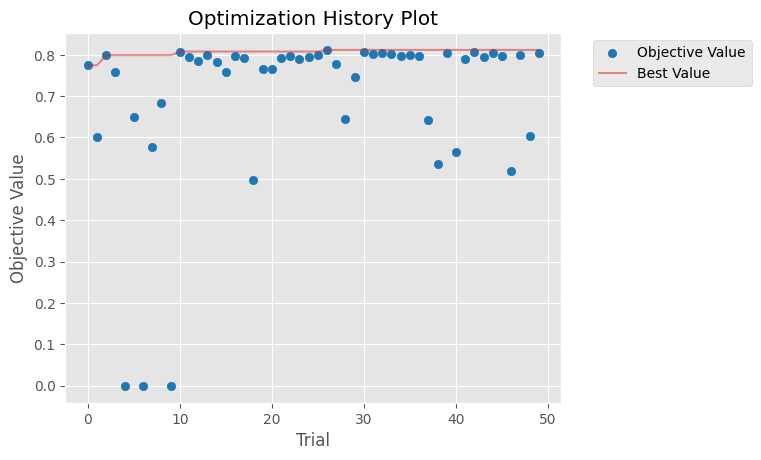

In [9]:
optuna.visualization.matplotlib.plot_optimization_history(study_rf)

<ipython-input-10-1eb49e18946d>:4: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_rf)
<ipython-input-10-1eb49e18946d>:6: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_rf)


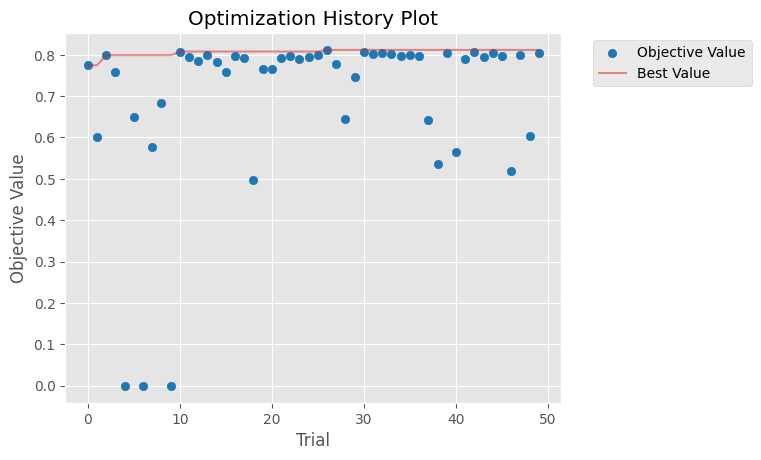

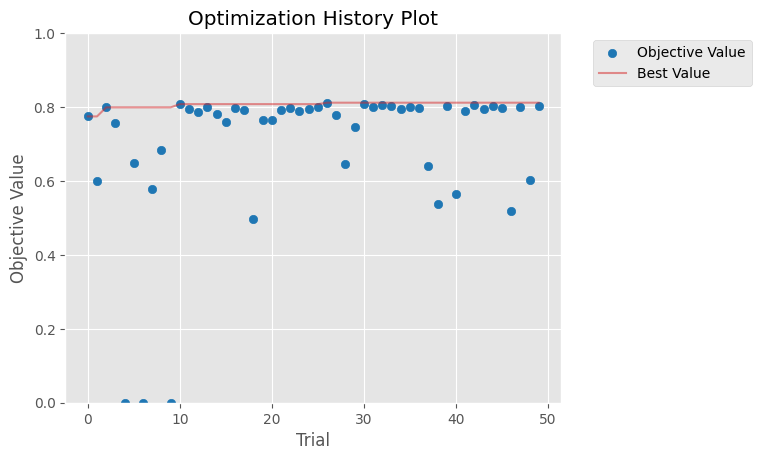

In [10]:
from optuna.visualization import matplotlib as optuna_matplotlib
import matplotlib.pyplot as plt
# Plot the optimization history in a different format
optuna.visualization.matplotlib.plot_optimization_history(study_rf)

optuna_matplotlib.plot_optimization_history(study_rf)

plt.ylim(0, 1)

plt.show()